## Ejemplos de embedding con all-MiniLM-L6-v2

- Este codigo se ha extraido de: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

In [5]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
# Se carga el modelo pre entrenado de all-MiniLM-L6-v2 de Hugging Face y su tokenizador
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

In [6]:
# Oraciones para generar el embedding
sentences = [
    "Life is great",
    "Life is amazing",
    "Machine learning is magic",
    "Machine learning is powerful",
    "Computers are a great tool",
    "Computers are our allies"
]

In [8]:
#Mean Pooling - utiliza el vector mascara para eliminar los pesos de los tokens que no son de interes como por ejemplo Stopwords.
def mean_pooling(model_output, attention_mask):
    # Todos los tokens calculados en el espacio vectorial que el modelo pre entrenado ya trae
    token_embeddings = model_output[0] 
    # Generacion del vector mascara (vector binario [1,0])
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float() 
    # Multiplicacion del vector original con la mascara para eliminar los pesos de los token no relevantes.
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Se generan los vectores tokenizados para cada frase de la lista
encoded_input = tokenizer(sentences, # Oraciones para hacer el embedding
                          padding=True,  # En caso de que las oraciones varien su tamaño, se rellenaran con tokens especiales que no aportaran peso al vector.
                          truncation=False,  # En caso de que una oracion supere el maximo de longitud de lo que puede ingerir el modelo, este lo truncara.
                          return_tensors='pt') # Formato del tensor, en este caso es un tensor de Pytorch

# Compute token embeddings
# no_grad() funcion para determinar que no se estan empleando los gradientes, siendo estos utilizados 
# en los entrenamientos para minimizar la funcion de coste del modelo
# tiene un gran aporte a la hora de generar eficiencia computacional, algo importante para nuestro proyecto.
with torch.no_grad():
    # Encoded input son tuplas con el vector de tokens y la mascara de atencion.
    model_output = model(**encoded_input)

# Aplicamos la funcion anteriormente declarada. Introducimos el vector de tokens y la mascara para que el modelo proporcione el embedding.
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# NNormalizacion de los emebddings
sentence_embeddings = F.normalize(sentence_embeddings, # Em,beddings proporcionados por el modelo
                                   p=2,  # Normalizacion L2(euclideana) esta normalizacion asegura que la suma de los elementos del vector sea 1, al igual que su magnitud.
                                   dim=1) # Valor que representa el numero de filas en el que se ha de aplicar la normalizacion. 

print(f'Longitud del embedding: {len(sentence_embeddings[0])}')
print("Sentence embeddings:")
print(sentence_embeddings)



Longitud del embedding: 384
Sentence embeddings:
tensor([[-0.0498,  0.0460,  0.0508,  ...,  0.0145, -0.0243, -0.0112],
        [-0.1064, -0.0009,  0.0486,  ...,  0.0173, -0.0300, -0.0067],
        [-0.0029, -0.0609,  0.0582,  ...,  0.0138, -0.0192, -0.0459],
        [ 0.0186, -0.0261,  0.0729,  ...,  0.0165,  0.0443, -0.0441],
        [-0.0359, -0.0082,  0.0642,  ...,  0.0492, -0.0003,  0.0216],
        [-0.0125,  0.0298,  0.0427,  ...,  0.0507, -0.0206, -0.0485]])


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


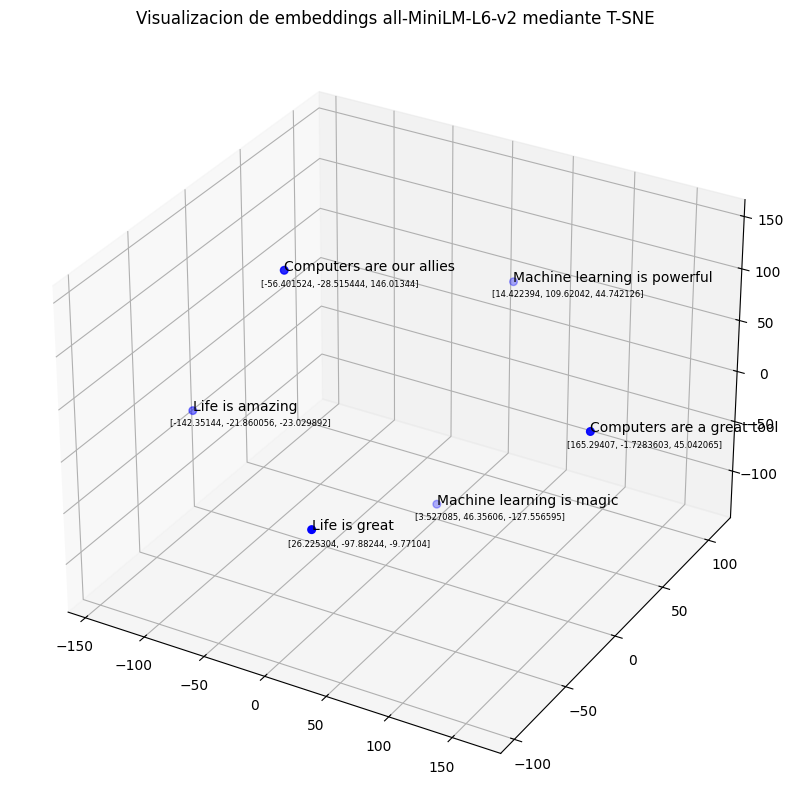

In [7]:
sentence_embeddings = np.array(sentence_embeddings)

# Reducir a 3 dimensiones usando t-SNE
tsne = TSNE(n_components=3, random_state=22, perplexity=len(sentence_embeddings)-1, n_iter=1000)  # Configura los hiperparámetros como sea necesario
embeddings_3d = tsne.fit_transform(np.array(sentence_embeddings))  # Convertir tensores de PyTorch a NumPy

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Dibujar puntos en 3D
ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], color='blue' ,s=30)

offset = 10
# Etiquetar cada punto
for i, txt in enumerate(sentences):
    ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], txt, fontsize=10)
    ax.text(embeddings_3d[i, 0]- offset, embeddings_3d[i, 1]-offset, embeddings_3d[i, 2]-offset, str(list(embeddings_3d[i])), fontsize=6)

ax.set_title("Visualizacion de embeddings all-MiniLM-L6-v2 mediante T-SNE")

plt.show()

In [5]:
Embed_1 = sentence_embeddings[0].reshape(1, -1)
Embed_2 = sentence_embeddings[1].reshape(1, -1)
Embed_4 = sentence_embeddings[4].reshape(1, -1)
Embed_5 = sentence_embeddings[5].reshape(1, -1)


print(f'<{sentences[0]}> y <{sentences[1]}> poseen un valor de similitud del coseno de {cosine_similarity(Embed_1, Embed_2)[0][0]}')
print(f'<{sentences[4]}> y <{sentences[5]}> poseen un valor de similitud del coseno de {cosine_similarity(Embed_4, Embed_5)[0][0]}')
print(f'<{sentences[0]}> y <{sentences[4]}> poseen un valor de similitud del coseno de {cosine_similarity(Embed_1, Embed_4)[0][0]}')


<Life is great> y <Life is amazing> poseen un valor de similitud del coseno de 0.84659743309021
<Computers are a great tool> y <Computers are our allies> poseen un valor de similitud del coseno de 0.5036420822143555
<Life is great> y <Computers are a great tool> poseen un valor de similitud del coseno de 0.28576189279556274


### Test con un documento entero

In [2]:
# Leo el archivo generado en el otro notebook
with open(r"..\Segmentacion_PDF\texto_para_resumen.txt", "r", encoding="utf-8") as archivo:
    texto_grande = archivo.read()

In [9]:
encoded_input = tokenizer(texto_grande, 
                          padding=True,  
                          truncation=False,  
                          return_tensors='pt')
with torch.no_grad():
    model_output = model(**encoded_input)

sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

Token indices sequence length is longer than the specified maximum sequence length for this model (22857 > 512). Running this sequence through the model will result in indexing errors


RuntimeError: The size of tensor a (22857) must match the size of tensor b (512) at non-singleton dimension 1